In [1]:
import tensorflow as tf
import numpy as np
import dataset as ds

trainToTestRatio = 0.8

dataset = np.load('faceFeatures_9216_normalized_labels_as_coord.npz')
samples = dataset['data'].shape[0]
sampleSize = dataset['data'].shape[1]
coordsCount = dataset['y'].shape[1]
splitIdx = int(samples*trainToTestRatio)
trainData = dataset['data'][:splitIdx]
trainY = dataset['y'][:splitIdx]
testData = dataset['data'][splitIdx:]
testY = dataset['y'][splitIdx:]

resultDataset = ds.TestsetDB()

In [2]:
resultData = np.zeros((resultDataset.rows(), sampleSize), np.float32)
for face in resultDataset.getFaces():
    resultData[face.id - 1, :] = face.image.reshape((sampleSize,)).astype(np.float32) / 255.0

def saveResult(resultY):
    for idx in range(resultY.shape[0]):
        face = resultDataset.getFace(idx + 1)
        for featureId in ds.allFeatures:
            x = (resultY[idx, featureId * 2] + 1) * (96 / 2.0)
            y = (resultY[idx, featureId * 2 + 1] + 1) * (96 / 2.0)
            face.setFeaturePosition(featureId, (x, y))
    resultDataset.write()

In [3]:
hiddenLayerSize = 100
outputSize = coordsCount

x = tf.placeholder(tf.float32, shape=[None, sampleSize])
y_ = tf.placeholder(tf.float32, shape=[None, outputSize])

# Hidden

W_hidden = tf.Variable(tf.truncated_normal((sampleSize, hiddenLayerSize), stddev=0.1))
b_hidden = tf.Variable(tf.constant(0.1, shape=(hiddenLayerSize,)))

hidden = tf.nn.relu(tf.matmul(x, W_hidden) + b_hidden)

# Output

W_output = tf.Variable(tf.truncated_normal((hiddenLayerSize, outputSize), stddev=0.1))
b_output = tf.Variable(tf.constant(0.1, shape=(outputSize,)))
y = tf.matmul(hidden, W_output) + b_output

# add overfitting control

In [4]:
#lossFunc = tf.nn.l2_loss(y - y_)
lossFunc = tf.sqrt(tf.reduce_mean((y - y_)**2))

train_step = tf.train.AdamOptimizer(1e-4).minimize(lossFunc)

In [5]:
epohs = 5000


init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

trainLoss = []
testLoss = []

for i in range(epohs):
    evalY=y.eval(feed_dict={x:trainData},session=sess)
    evalY[~np.isnan(trainY)]=trainY[~np.isnan(trainY)]
    if i % 100 == 0:
        train = lossFunc.eval(feed_dict={x:trainData, y_:evalY}, session=sess)
        evalTestY=y.eval(feed_dict={x:testData},session=sess)
        evalTestY[~np.isnan(testY)]=testY[~np.isnan(testY)]
        test = lossFunc.eval(feed_dict={x:testData, y_:evalTestY}, session=sess)
        
        print('train:', train, 'test:', test)
    train_step.run(feed_dict={x:trainData, y_:evalY}, session=sess)

train: 2.25668 test: 1.42911
train: 0.262002 test: 0.172964
train: 0.188461 test: 0.123195
train: 0.137802 test: 0.0937828
train: 0.112871 test: 0.0777107
train: 0.100112 test: 0.0700956
train: 0.0850016 test: 0.0608362
train: 0.0798553 test: 0.0581358
train: 0.0764691 test: 0.0562089
train: 0.0737206 test: 0.0550299
train: 0.0713729 test: 0.0538086
train: 0.0692725 test: 0.0528545
train: 0.0674236 test: 0.0520107
train: 0.0658104 test: 0.0512074
train: 0.0643842 test: 0.0504713
train: 0.0630362 test: 0.0498186
train: 0.0617696 test: 0.049161
train: 0.0605943 test: 0.0485985
train: 0.0595222 test: 0.0478695
train: 0.0583861 test: 0.0471085
train: 0.0573205 test: 0.0464634
train: 0.0563582 test: 0.0459903
train: 0.055373 test: 0.0454265
train: 0.0545018 test: 0.0450139
train: 0.0537465 test: 0.0447965
train: 0.0529594 test: 0.0443968
train: 0.0522435 test: 0.0439797
train: 0.0516176 test: 0.0436858
train: 0.0509964 test: 0.043449
train: 0.0504388 test: 0.0431856
train: 0.0499008 test: 0

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def addFeatures(ax, features, isFill = True):
    for i in range(0, 30, 2):
        x = (features[i] + 1) * (96 / 2.0)
        y = (features[i + 1] + 1) * (96 / 2.0)
        ax.add_patch(patches.Circle((x,y),1, fill = isFill))
    
def showFace(data, features, expectedFeatures = None):
    fig,ax = plt.subplots()
    addFeatures(ax, features)
    if not expectedFeatures is None:
        addFeatures(ax, expectedFeatures, False)
    plt.imshow(data.reshape(96, 96), cmap = 'gray')

In [13]:
evalTrain=y.eval(feed_dict={x:trainData},session=sess)
showTrain = lambda idx : showFace(trainData[idx], evalTrain[idx], trainY[idx])

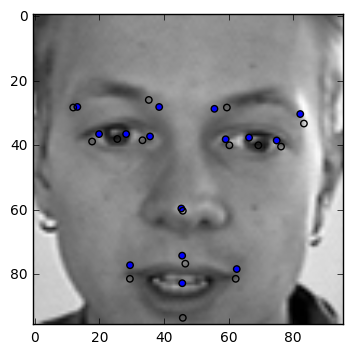

In [14]:
showTrain(20)

In [6]:
evalResult=y.eval(feed_dict={x:resultData}, session=sess)
showResult = lambda idx : showFace(resultData[idx], evalResult[idx])

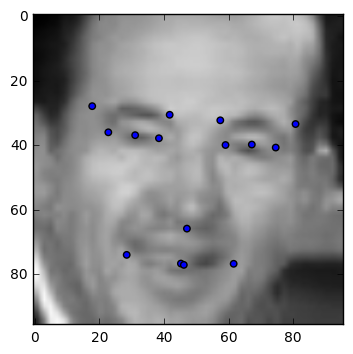

In [9]:
showResult(1780)

In [13]:
saveResult(evalResult)

In [12]:
evalResult[evalResult < -1.0] = -1.0
evalResult[evalResult > 1.0] = 1.0

In [ ]:
def showFace(face):
    fig,ax = plt.subplots()
    for key, value in face.features.items():
        ax.add_patch(patches.Circle(value,1))
    ax.imshow(face.image, cmap = 'gray')